## Imports

In [ ]:
import pandas as pd
from music21 import converter, instrument, note, chord
from sklearn.preprocessing import LabelEncoder
import itertools
import warnings
import random
warnings.filterwarnings("ignore")
import numpy as np
import ast
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Activation
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import to_categorical

In [70]:
path = 'data\maestro-v3.0.0.csv'
df = pd.read_csv(path)

#comp = df.groupby('canonical_composer')['midi_filename'].count().reset_index().sort_values(by='midi_filename')['canonical_composer'].to_list()[10:11]
#df = df[df['canonical_composer'].isin(comp)]

## Exploration

In [ ]:
morceau = random.randint(0,df.shape[0])
midi = converter.parse(df['midi_filename'].to_list()[morceau])
midi.show('midi')

## Extraction et preprocessing

In [71]:
df_i = df.groupby('canonical_composer')['midi_filename'].count().reset_index().sort_values(by='midi_filename')
df_i = df_i[df_i['midi_filename']>2]
comp = df_i['canonical_composer'].to_list()[20:25]
df = df[df['canonical_composer'].isin(comp)]

In [72]:
def extraction_notes(file):
    midi = converter.parse(file)
    L_notes = []
    for e in midi.recurse().notes:
        if e.isNote:
            N = e.pitch.midi
            if N > 48:
                L_notes.append(N)
        elif e.isChord:
            accords = [n.midi for n in e.pitches]
            N = max(accords)
            if N > 48:
                L_notes.append(N)
    if len(L_notes)<8:
        return 'null'
    else:
        return L_notes 
    
def ex_notes_tab(df,col_out):
    df['midi_file_data'] = 'data/'+df['midi_filename']
    df[col_out] = df['midi_file_data'].apply(extraction_notes)
    return df[df[col_out]!='null']

def colonnes(df):
    df_expanded = df['X'].apply(pd.Series)
    df_expanded['y'] = df['y']
    return df_expanded

def sequence_list(L):
    sequence_length = 8

    input_sequences = []
    output_notes = []

    for i in range(len(L) - sequence_length):
        seq_in = L[i:i + sequence_length]  
        seq_out = L[i + sequence_length]  
        input_sequences.append(seq_in)
        output_notes.append(seq_out)

    return input_sequences,output_notes

def sequence(dff):
    X,y = [],[]
    for k in dff['notes'].to_list():
        xtemp,ytemp = sequence_list(k)
        X.append(xtemp)
        y.append(ytemp)
    X=list(itertools.chain(*X))
    y=list(itertools.chain(*y))

    return pd.DataFrame({"X":X,"y":y})

def preprocessing(df):

    dftrain = colonnes(sequence(ex_notes_tab(df[df['split']=='train'],'notes')))
    dftest = colonnes(sequence(ex_notes_tab(df[df['split']=='test'],'notes')))
    dfval = colonnes(sequence(ex_notes_tab(df[df['split']=='validation'],'notes')))

    return dftrain,dftest,dfval

dftrain,dftest,dfval = preprocessing(df)

In [84]:
dfval.max()

0    108
1    108
2    108
3    108
4    108
5    108
6    108
7    108
y    108
dtype: int64

In [85]:
X_train

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

## Modélisation

In [ ]:
import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Activation
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import to_categorical

# --- Chargement et prétraitement des données ---

def parse_cell(cell):
    return np.array(ast.literal_eval(cell), dtype=np.int32)

def df_to_tensor(df):
    num_classes=
    # Séquence d'entrée
    col = [i for i in df.columns if i!='y']
    X_raw = df[col].values.astype(int)  # (nb_samples, 8)
    X = to_categorical(X_raw, num_classes=num_classes)  # (nb_samples, 8, 128)

    # Label (y), one-hot encodé
    y_raw = df["y"].astype(int).values                  # (nb_samples,)
    y = to_categorical(y_raw, num_classes=num_classes)  # (nb_samples, 128)

    return X, y


X_train, y_train = df_to_tensor(pd.DataFrame(dftrain))
X_val, y_val = df_to_tensor(pd.DataFrame(dfval))
X_test, y_test = df_to_tensor(pd.DataFrame(dftest))

# --- Définition du modèle ---
sequence_length = 8
num_notes = 128

model = Sequential()
model.add(LSTM(512, input_shape=(sequence_length, num_notes), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(512))
model.add(Dropout(0.3))
model.add(Dense(num_notes))
model.add(Activation('softmax'))

# Compilation avec cross-entropy + métrique MSE en plus (optionnelle)
optimizer = RMSprop(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['mse'])

# Affichage de l'architecture
model.summary()

# --- Entraînement ---
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=2,
    batch_size=32
)




Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 8, 512)         │     1,312,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 8, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 512)            │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 128)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,477,632 (13.27 MB)

 Trainable params: 3,477,632 (13.27 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
15005/15005 ━━━━━━━━━━━━━━━━━━━━ 556s 37ms/step - loss: 3.3158 - mse: 0.0074 - val_loss: 3.1993 - val_mse: 0.0074
Epoch 2/2
15005/15005 ━━━━━━━━━━━━━━━━━━━━ 535s 36ms/step - loss: 3.1651 - mse: 0.0073 - val_loss: 3.1815 - val_mse: 0.0074


In [83]:
from tensorflow.keras.utils import to_categorical

def generate_sequence(model, seed_sequence, length=50, noise_std=0.0, num_classes=(128-49)):
    generated = list(seed_sequence)

    for _ in range(length):
        # Garder les 8 dernières valeurs et les transformer en one-hot
        input_seq_raw = generated[-8:]
        input_seq = to_categorical(input_seq_raw, num_classes=num_classes).reshape(1, 8, num_classes)

        # Prédiction
        pred_distribution = model.predict(input_seq, verbose=0)[0]  # (128,)
        
        # On ajoute un bruit (dans l'espace des logits, pas idéal, mais simple)
        if noise_std > 0.0:
            pred_distribution += np.random.normal(0, noise_std, size=pred_distribution.shape)
        
        # On prend la note la plus probable (ou on peut faire un tirage)
        next_val = int(np.argmax(pred_distribution))
        generated.append(next_val)

    return generated


seed_sequence = dftest.iloc[0, :8].astype(int).tolist()
generated = generate_sequence(model, seed_sequence=seed_sequence, length=50, noise_std=2.0)
print(generated)



InvalidArgumentError: Graph execution error:

Detected at node sequential_4_1/lstm_8_1/while/body/_1/sequential_4_1/lstm_8_1/while/lstm_cell_1/MatMul defined at (most recent call last):
<stack traces unavailable>
Matrix size-incompatible: In[0]: [1,79], In[1]: [128,2048]
	 [[{{node sequential_4_1/lstm_8_1/while/body/_1/sequential_4_1/lstm_8_1/while/lstm_cell_1/MatMul}}]] [Op:__inference_one_step_on_data_distributed_1253639]

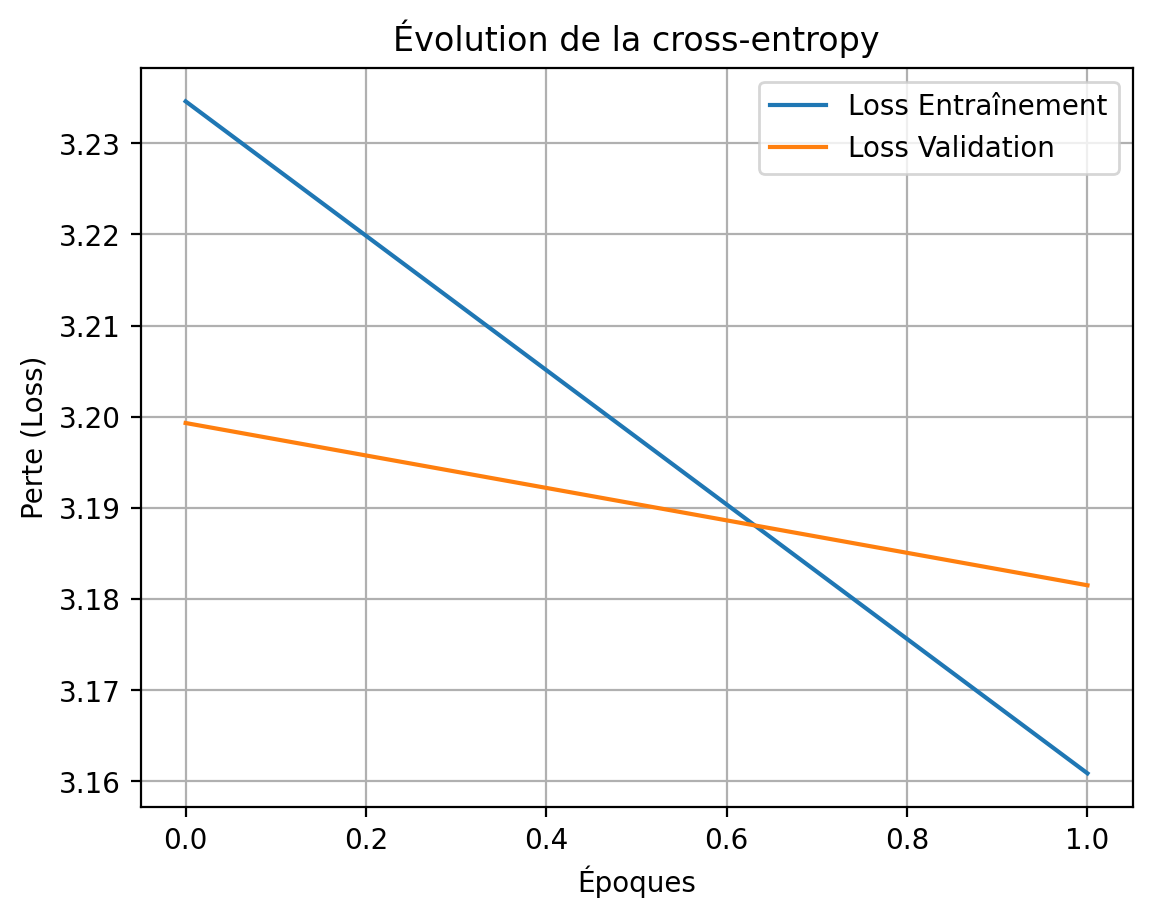

In [75]:
# --- Visualisation de la cross-entropy ---
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(loss, label='Loss Entraînement')
plt.plot(val_loss, label='Loss Validation')
plt.title('Évolution de la cross-entropy')
plt.xlabel('Époques')
plt.ylabel('Perte (Loss)')
plt.legend()
plt.grid(True)
plt.show()

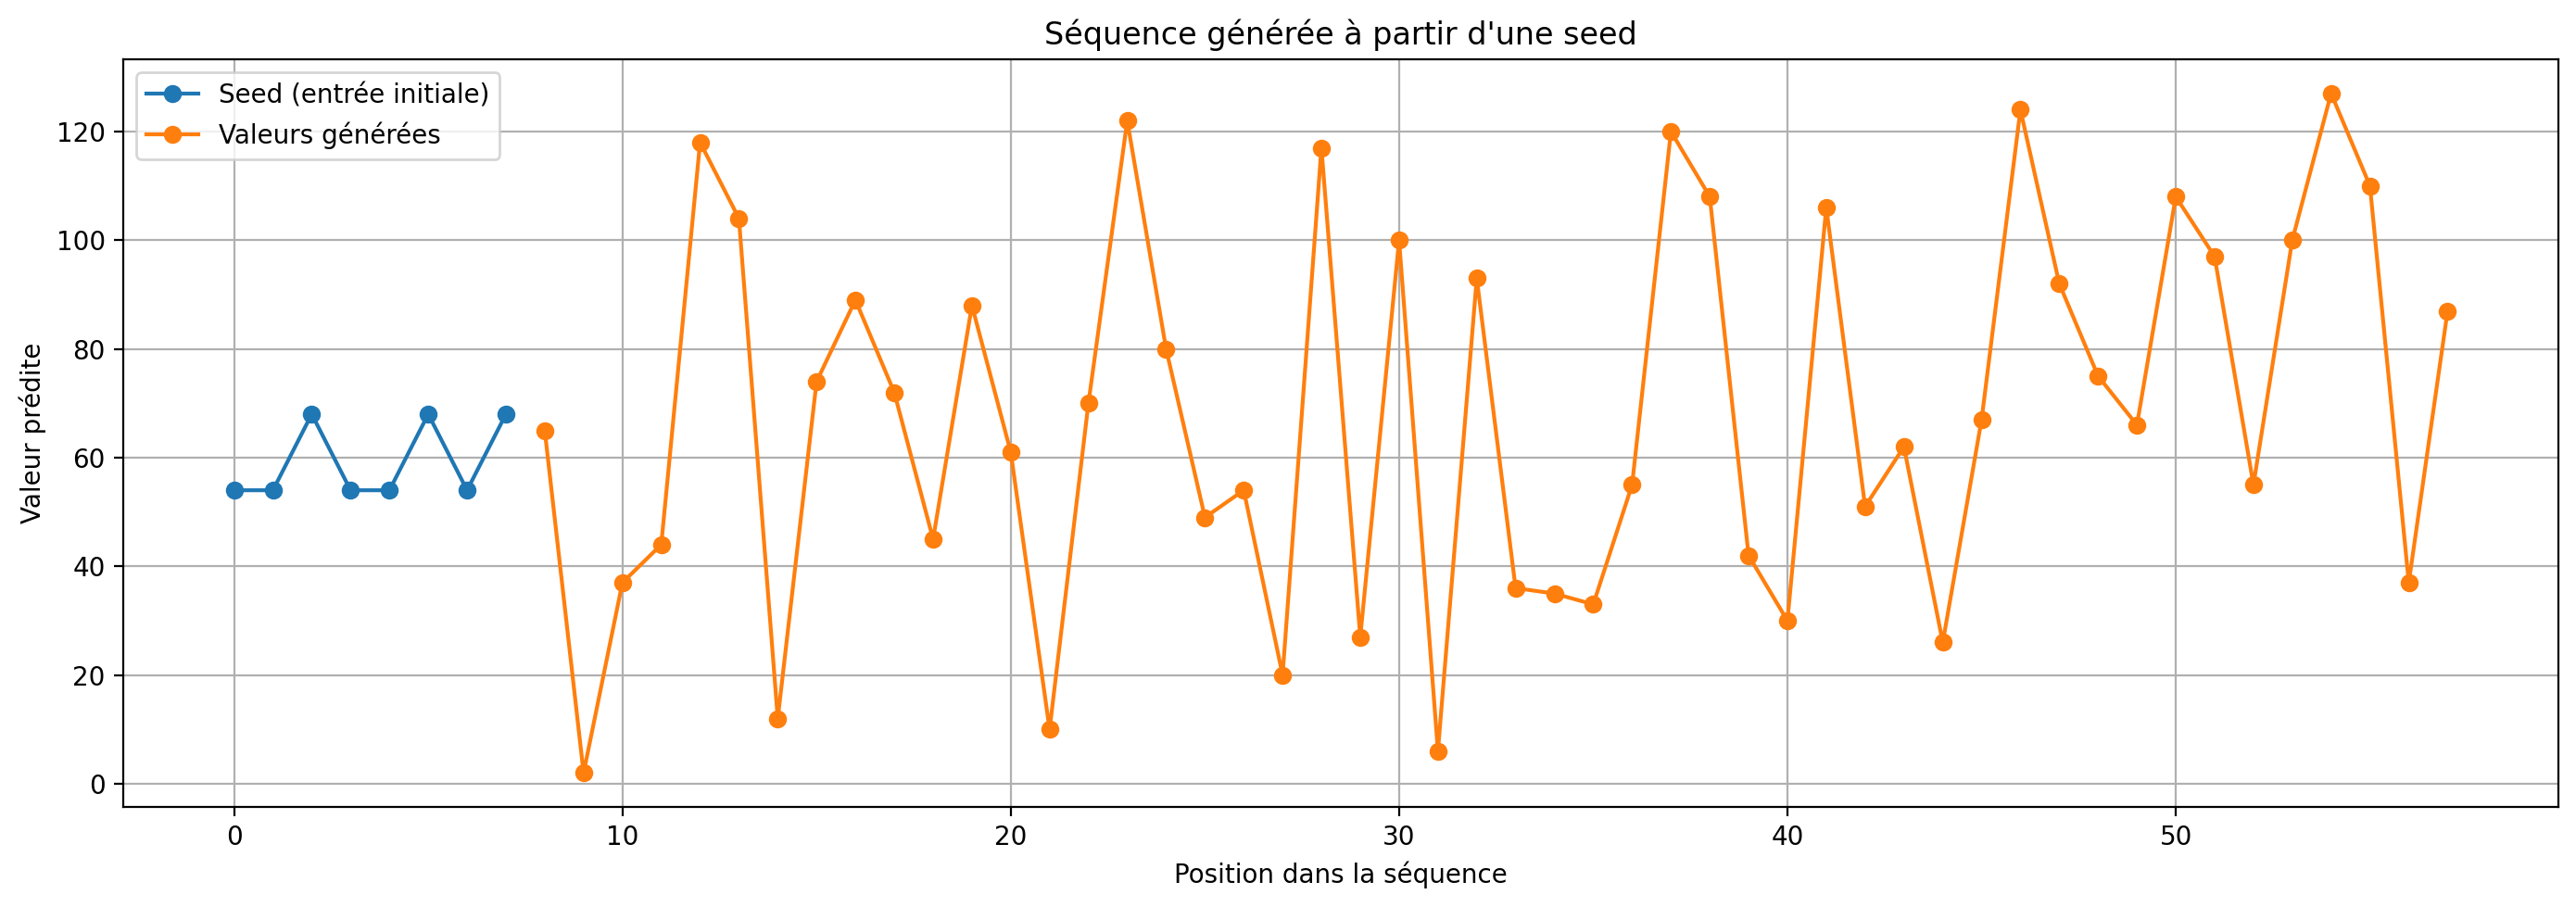

In [76]:
import matplotlib.pyplot as plt
seed = seed_sequence
plt.figure(figsize=(14, 5))
plt.plot(range(len(seed)), seed, label='Seed (entrée initiale)', marker='o')
plt.plot(range(len(seed), len(generated)), generated[len(seed):], label='Valeurs générées', marker='o')
plt.title("Séquence générée à partir d'une seed")
plt.xlabel("Position dans la séquence")
plt.ylabel("Valeur prédite")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [77]:
from music21 import stream,note
from copy import deepcopy
s = stream.Stream()

# Paramètres : durée de chaque note ou accord
duration = 0.5  # durée en quarts de note

# Ajoute chaque note ou accord à la Stream

for e in generated:
    e = note.Note(e)
    e.quarterLength = duration
    s.append(e)

# Exporte en MIDI
#s.write('midi', fp='test_v4_06.mid')
s.show('midi')